# Data Challenge: The Clairvoyant Contrusctor

Daniella Patton

Last Edit: 2/20/20

# 1     Executive Summary

The goal of this challenge is to forecast core construction material costs.

Data: Pricing information (per unit, in dollars) for the company’s past 
purchases over the past ten years in CSV.

Outcome: Forecast the price of each commodity up to six months into the future. Our manager wants to understand when a commodity price is about to increase temporarily, to either buy the commodity early or wait until after the temporary increase.


In this challenge, we had to face numerous instances if missing data and could only forecast the future cost of price per unit based on previous costs. Most products demonstrated both seasonal and trends with time. To complete this problem a SAMIRA machine learning model was used. A simple function was written such that a contractor can type in both a date (i.e., anytime before 2025) and a product. This function will notify the company of the best month to purchase the product in the following 6 month and the amount (i.e., in terms of price/unit) that could be saved.  

In [2]:
# Loading Required Packages
import pandas as pd
import os
from datetime import date
from dateutil import parser
from datetime import datetime
from pylab import rcParams
import math
import itertools
import impyute

# Time series models
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm


# Creating figures
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sn

pd.plotting.register_matplotlib_converters()

Importing plotly failed. Interactive plots will not work.


In [652]:
# Read in the csv file
os.chdir('/Users/Owner/Desktop/InsightFellows/DataChallenge1')
print(os.getcwd())  # Prints the current working directory
construction_materials = pd.read_csv('construction_material_prices_2008_2018.csv')

/Users/Owner/Desktop/InsightFellows/DataChallenge1


# 2     Basic EDA
Questions that will be explored in the following section: 

1) What is the size of the df?

2) Are we dealing with missing values?

3) Are variables correlated?    

4) Differences in the mean/SD between variables?

In [617]:
# We are interested in estimating costs for 5 different products.
construction_materials.columns

Index(['Unnamed: 0', 'price_steel', 'price_rebar', 'price_glass',
       'price_concrete', 'price_plywood'],
      dtype='object')

In [618]:
# At surface value, it appears we have a lot of data to work with (i.e., ~ 3000 data points)
construction_materials.shape

(2945, 6)

In [619]:
'''
I noticed that there were rows where we did not have information for any of the variables.
These rows were dropped in order to be ecluded from further anlalysis. 
Updated df size: (2735, 6)
'''
construction_materials.head(20)
construction_materials = construction_materials.dropna(subset=['price_steel', 'price_rebar', 'price_glass', 
                                      'price_concrete', 'price_plywood'], how='all')

In [620]:
'''
However, we are missing quite a bit of input data for all of the prodcuts of interest. 
Imputation and some type of averaging will be required.

Despite dropping rows, we are dealing with anywhere from 62 to 1288 missing variables
'''
construction_materials.isna().sum()

Unnamed: 0           0
price_steel        426
price_rebar       1086
price_glass       1263
price_concrete    1288
price_plywood       62
dtype: int64

In [621]:
'''
The most expensive product on average, is glass, followed concrete, rebar, plywood, and steel. 
Based on the std it also appears that the more expensive products (i.e., concrete, rebar, and glass)
fluctuate in price per unit more than the cheapest product, plywood.

However, we will need to look at the time series plots to better under what these fluctuations look like. 
'''
construction_materials.describe()

,price_steel,price_rebar,price_glass,price_concrete,price_plywood
count,2309.000000,1649.000000,1472.000000,1447.000000,2673.000000
mean,12.611319,18.306339,29.997962,26.000636,12.775067
std,6.038862,8.587938,6.524622,7.314764,3.931698
min,3.062500,3.000000,16.000000,10.416667,5.000000
25%,8.500000,12.071429,25.000000,20.559028,10.125000
50%,10.500000,16.500000,29.000000,25.043478,12.125000
75%,14.833333,22.500000,35.000000,30.000000,14.333333
max,41.000000,55.000000,48.000000,50.000000,34.000000


# Summary: Basic EDA

The company wants to predict the future price of five different products
(i.e., glass, steel, rebar, concrete, and plywood).

All of the products of interest are working with variables with many missing values. We will need to find a way to impute or average our results in order to make predictions. 

The most expensive product on average, is glass, followed concrete, rebar, plywood, and steel. 
Based on the std it also appears that the more expensive products (i.e., concrete, rebar, and glass)
fluctuate in price per unit more than the cheapest product, plywood.




# 3     More Detailed EDA

Key questions explored in this section include:

1) Do the costs of products correlate with each other?
    
2) What does the histogram look like? Are the costs normally distributed?
    
3) What does the data look like?
    
4) If we decompose the data are their seasonality effects or other noteworthy trends?

In [653]:
# Converting the data informaiton is convertine to datetime format and rename collumn name

construction_materials['Unnamed: 0'] = construction_materials['Unnamed: 0'].apply(lambda x: 
                                                                      parser.parse(x).date())
construction_materials = construction_materials.rename(columns={'Unnamed: 0': 'Date'})

In [654]:
# Question: 1) Do the costs of prodcuts corrrelate with eachother?
# Correlation between features

corr_matrix = construction_materials.copy()
corr_matrix = corr_matrix.drop(['Date'],axis =1)
corr_matrix = corr_matrix.rename(columns={'price_steel': 'Steel ($/unit)',
                                         'price_rebar': 'Rebar ($/unit)',
                                         'price_glass': 'Glass ($/unit)',
                                         'price_concrete': 'Concrete ($/unit)',
                                         'price_plywood': 'Plywood ($/unit)'})

corr = corr_matrix.corr()
corr.style.background_gradient(cmap='coolwarm')

,Steel ($/unit),Rebar ($/unit),Glass ($/unit),Concrete ($/unit),Plywood ($/unit)
Steel ($/unit),1,0.767352,0.149144,0.0597948,0.00766707
Rebar ($/unit),0.767352,1,0.00211771,-0.134875,-0.0855105
Glass ($/unit),0.149144,0.00211771,1,0.319703,0.102949
Concrete ($/unit),0.0597948,-0.134875,0.319703,1,0.27328
Plywood ($/unit),0.00766707,-0.0855105,0.102949,0.27328,1


Based on the correlation amongst the features, it appears that steel and rebar are more tightly correlated in comparison to all of the other products compared. In addition, it appears that concrete and glass, as well as concrete and plywood, are correlated. 
One reason why these points might be related is that there are seasonality or other trends. 

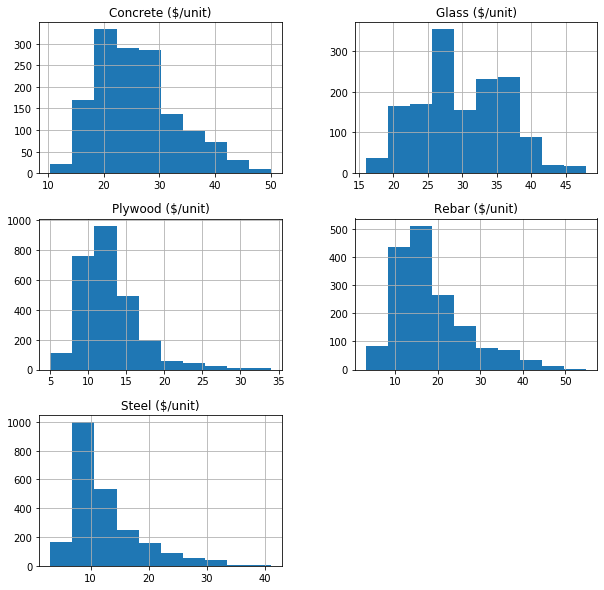

In [655]:
# Question: 2) What does the histogram look like. Are the costs normally distirbuted?

plt.rcParams["figure.figsize"] = [10,10] 
hist = corr_matrix.hist()

Generally speaking, the range of costs over the years is non-linearly distributed. 
It appears that their is a gammma distribution for most poducts.  

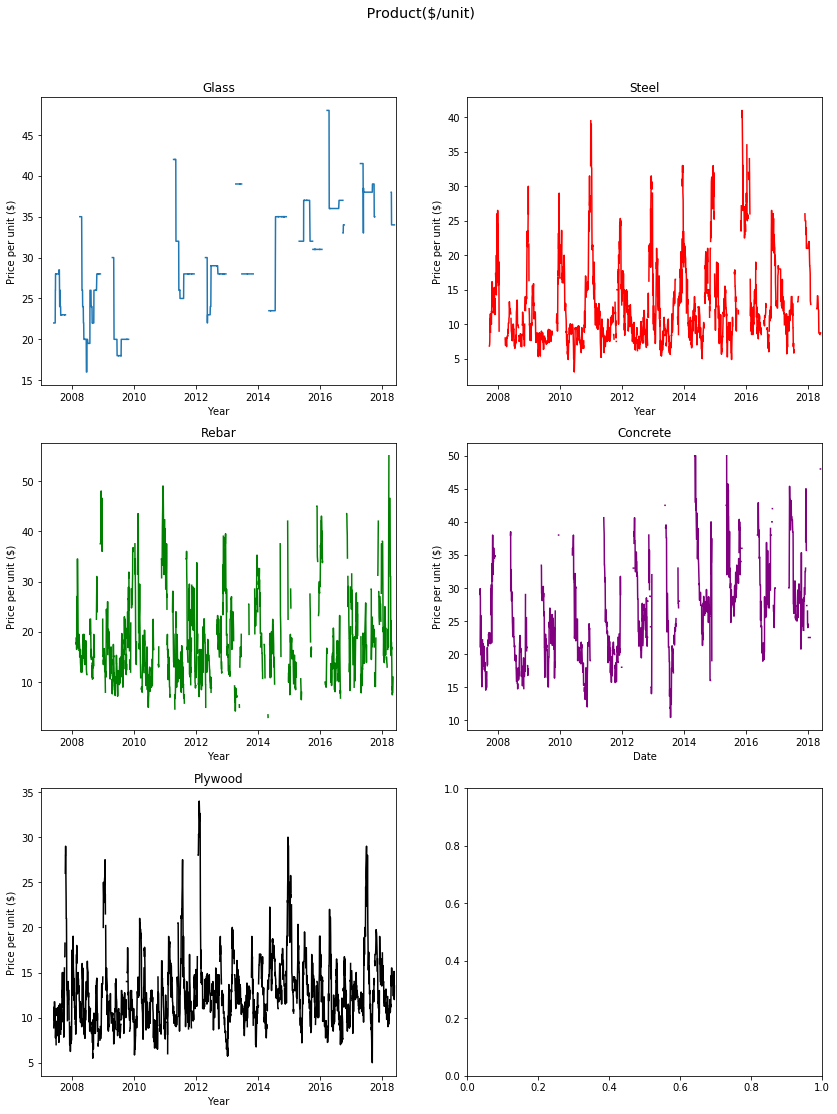

In [656]:
# Question: 3) What does the data look like?
# Plotting the Price per unit over time to visualize if their are any obvious trends

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,18))
st = fig.suptitle(" Product($/unit)", fontsize="x-large")
# shift subplots down:
st.set_y(0.95)


ax11 = axes[0][0]
ax12 = axes[0][1]
ax21 = axes[1][0]
ax22 = axes[1][1]
ax13 = axes[2][0]

# gca stands for 'get current axis'
ax = plt.gca()
construction_materials.plot(kind='line',x='Date',y='price_glass',
                            legend=False, ax=ax11)
construction_materials.plot(kind='line',x='Date',y='price_steel', 
                            legend=False, color='red', ax=ax12)
construction_materials.plot(kind='line',x='Date',y='price_rebar',
                            legend=False, color='green', ax=ax21)
construction_materials.plot(kind='line',x='Date',y='price_concrete',
                            legend=False, color='purple', ax=ax22)
construction_materials.plot(kind='line',x='Date',y='price_plywood',
                            legend=False, color='black', ax=ax13)
# Set labels
ax11.set_title('Glass')
ax11.set_ylabel('Price per unit ($)')
ax11.set_xlabel('Year')

ax12.set_title('Steel')
ax12.set_ylabel('Price per unit ($)')
ax12.set_xlabel('Year')

ax21.set_title('Rebar')
ax21.set_ylabel('Price per unit ($)')
ax21.set_xlabel('Year')

ax22.set_title('Concrete')
ax22.set_ylabel('Price per unit ($)')
ax11.set_xlabel('Year')


# Add title and axis names
ax13.set_title('Plywood')
ax13.set_ylabel('Price per unit ($)')
ax13.set_xlabel('Year')

plt.show()

Interesting trends to note:

1) It appears that glass is only purchased sporadically and there is quite of data missing in chunks. 
   This may mean that the product is likely to purchase less frequently.
    
2) Steel, rebar, and concrete appear to have a cyclical nature to them.
    
3) It appears that concrete is not purchased at the same time every year. 

In [657]:
def date_to_datetime(the_date):
    ''' Change the date to date_time to convert all plots to a series for analysis
        using SAMIRA
    '''
    date_time_r = datetime(the_date.year, the_date.month, the_date.day)
    return date_time_r

construction_materials['Date'] = construction_materials['Date'].apply(lambda x: 
                                                                      date_to_datetime(x))
construction_materials = construction_materials.set_index('Date')

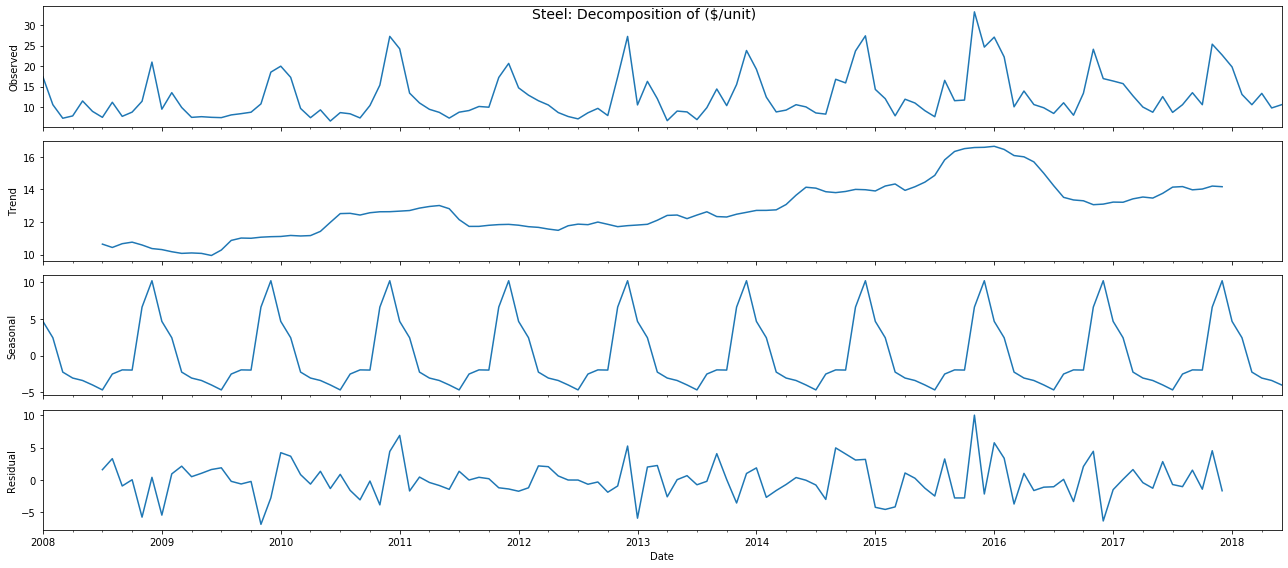

In [658]:
# Question: 4) If we decompose the data are their seasonality effects or other noteworthy trends?

# Plotting the Price per unit over time of steel to visualize if their are any obvious trends
# This will be used as a base case to decide what type of engineering should be used to impute/fill 
# the missing data
    
#The options are: Random, Mean, Median, Last Obs. Carired Forward, 
#                  Carried Backward, Linear Interpolation, Moving Average                 


# Due to the amount of missing data, I will be predicting the average cost per month
# Impute Nas with the means just as a base case to look at the model.

steel = construction_materials['price_steel'].resample('MS').mean()
steel = steel['2008':]
# Missing 5 values, replace with median for first pass
steel = steel.fillna(steel.median())



def decomp_plots(series, title):
    ''' This function automically decomposes a series of data so that the trends can be more 
    easily viaulized. 
    '''
    rcParams['figure.figsize'] = 18, 8
    decomposition = sm.tsa.seasonal_decompose(series, model='additive')
    fig = decomposition.plot()
    plt.suptitle(title, fontsize=14)
    plt.show()


decomp_plots(steel, 'Steel: Decomposition of ($/unit)') 

There is a seasonality trend. A moving window approach will be used to account for missing values for this data as well as other data.


# 4     SARIMA

I will be using SARIMA to prdict future costs of the products. 
Seasonal Autoregressive Integrated Moving Average is an extension of ARIMA that explicitly supports 
univariate time series data with a seasonal component.
It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA)
for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

In [659]:
# Deining the functions used for subsequent analysis

# Definition to automatically split the data into training and testing
def train_test_split_ts(series):
    ''' 
    This function splits the data into training (2008 - 2016) and testing (2016 - 2018) sets in order to 
    create and validate the model.
    '''
    train = series['2008':'2016']
    test = series['2016':]
    return train, test


# Selecting the best hyperparameters for each model based on the aic value
def optmize_arima(series):
    '''
    This is a function that will test the various hyperperamters used in the ARIMA model (p,d,q)
    and (AR, I, MA) in order to optimize our solution based off of the trainign data. 
    '''
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(series,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
                

# Concrete look for a pattern in the seasonality
def fit_predictions(model_fit, steps_out_to_predict, actual_values):
    """
    This function predicts the SARIMA model out a certain designated number of steps,
    and compares the predictions to the actual values. The root mean squared error and
    the mean absolute error are calculated, comparing the predicted and actual values.
    The function returns the predicted values and their respective confidence intervals.
    Args:
        model_fit:  SARIMA model.
        steps_out_to_predict: Int. Number of steps out to predict the time series.
        actual_values: Series of actual time series values.
    Outputs:
        mean_predicted_values: Series of predicted time series values.
        confidence_interval_predicted_values: Dataframe, containing upper and lower thresholds of the
        confidence interval
    """
    predicted_values = model_fit.get_forecast(steps=steps_out_to_predict)
    mean_predicted_values = predicted_values.predicted_mean
    confidence_interval_predicted_values = predicted_values.conf_int()
    #Compare the actual to the predicted values using RMSE and MAE metrics
    rmse, mae = quantify_rmse_mae(mean_predicted_values, actual_values)
    print("Root mean squared error: ", str(rmse))
    print("Mean absolute error: ", str(mae))
    return mean_predicted_values, confidence_interval_predicted_values
    
def quantify_rmse_mae(predicted_values, actual_values):
    """
    This function calculates the root mean squared error and mean absolute error for 
    the predicted values, when compared to the actual values. These helps help us to
    gauge model performance. 
    Args:
        predicted_values: Series of predicted time series values.
        actual_values: Corresponding series of actual time series values.
    Outputs:
        rmse: Float. Root mean squared error.
        mae: Float. Mean absolute error.
    """
    #calcuate the mean squared error of the model
    rmse = math.sqrt(mean_squared_error(actual_values, predicted_values))
    #Calculate the mean absolute error of the model 
    mae = mean_absolute_error(actual_values, predicted_values)
    #Return the MSE and MAE for the model
    return rmse, mae

# 4a     SARIMA: Steel 

In [660]:
# Preparing the data (filling for missing values and resampling)
steel = construction_materials['price_steel'].resample('MS').median()
# Missing 5 values, replace with median
steel = steel.rolling(4,min_periods=1,).median()
steel = steel.dropna()
    
# Use up to 2018 for Training 
steel_train, steel_test = train_test_split_ts(steel)

In [661]:
#optmize_arima(steel_train)
# ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:388.82779374249156

steel_mod = sm.tsa.statespace.SARIMAX(steel_train,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

steel_results = steel_mod.fit()
print(steel_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0159      0.100     -0.160      0.873      -0.212       0.180
ar.S.L12      -0.2633      0.145     -1.813      0.070      -0.548       0.021
ma.S.L12      -0.6765      0.128     -5.268      0.000      -0.928      -0.425
sigma2         2.9611      0.375      7.897      0.000       2.226       3.696


In [662]:
mean_predicted_values, confidence_interval_predicted_values = fit_predictions(steel_mod.fit(), 
                                                                              len(steel_test), 
                                                                              steel_test)

Root mean squared error:  3.8303230036463356
Mean absolute error:  2.663481926065104


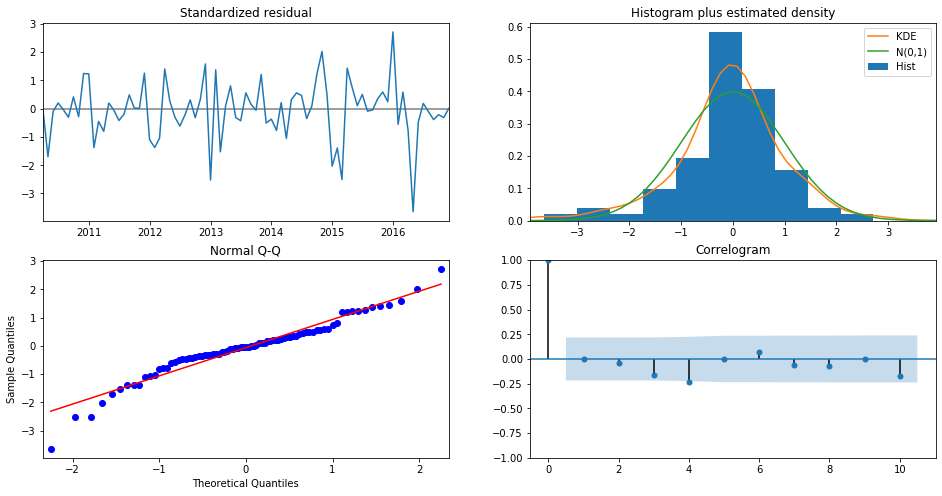

In [663]:
steel_results.plot_diagnostics(figsize=(16, 8))
plt.show()

Using the SARIMA is a good model to use for predicting the future cost of steel.

Root mean squared error:  3.878074762725714
Mean absolute error:  2.686388400885698

# 4b     SARIMA: Rebar

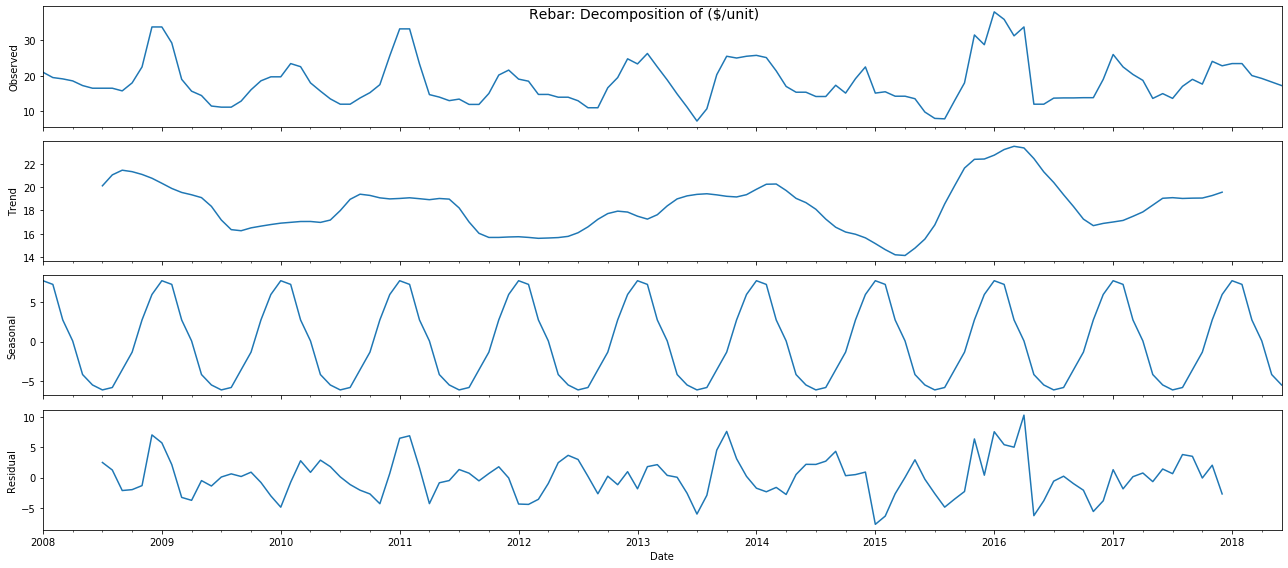

In [664]:
rebar = construction_materials['price_rebar'].resample('MS').median()
rebar = rebar['2008':]

rebar = rebar.rolling(4,min_periods=1,).median()
rebar = rebar.dropna()

decomp_plots(rebar, 'Rebar: Decomposition of ($/unit)') 

# Train/Test Split
rebar_train, rebar_test = train_test_split_ts(rebar)

In [665]:
#optmize_arima(rebar_train)
# ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:451.6713481085063

rebar_mod = sm.tsa.statespace.SARIMAX(rebar_train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

rebar_results = rebar_mod.fit()
print(rebar_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6078      0.114      5.335      0.000       0.385       0.831
ma.L1         -1.0000    288.980     -0.003      0.997    -567.391     565.391
ar.S.L12      -0.5912      0.186     -3.173      0.002      -0.956      -0.226
ma.S.L12      -0.5837      0.180     -3.239      0.001      -0.937      -0.231
sigma2        12.3054   3556.387      0.003      0.997   -6958.085    6982.696


In [666]:
mean_predicted_values, confidence_interval_predicted_values = fit_predictions(rebar_mod.fit(), 
                                                                              len(rebar_test), 
                                                                              rebar_test)

Root mean squared error:  8.503857798985079
Mean absolute error:  5.898480887176836


The RMSE Using the SARIMA was higher for rebar than for steel. However, this model still
performs adequately well to use as a prediction model. 


Root mean squared error:  8.592061517977688
Mean absolute error:  5.917512295585774

# 4c     SARIMA: Glass

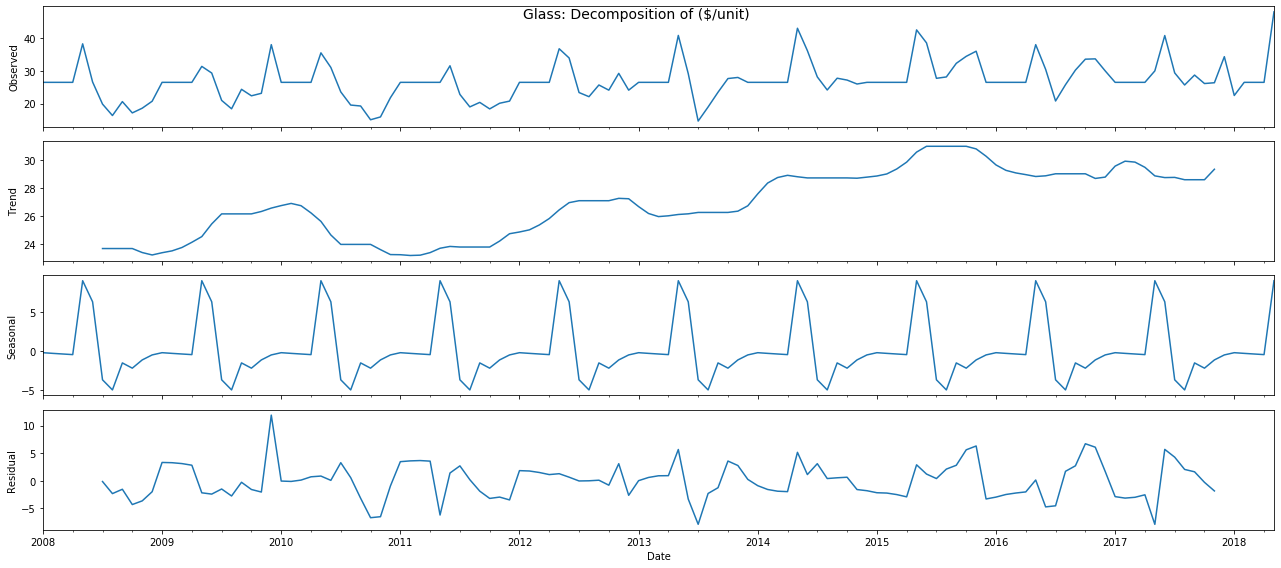

In [667]:
glass = construction_materials['price_glass'].resample('MS').median()
glass = glass['2008':]

# Missing 5 values, replace with median
glass = glass.rolling(4,min_periods=1,).median()
glass = concrete.fillna(glass.median())

decomp_plots(glass, 'Glass: Decomposition of ($/unit)') 

# Train/Test Split
glass_train, glass_test = train_test_split_ts(glass)

In [668]:
# optmize_arima(glass_train)
# ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:60.630399440296806

glass_mod = sm.tsa.statespace.SARIMAX(glass_train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

glass_results = glass_mod.fit()
print(glass_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5413      0.090      6.012      0.000       0.365       0.718
ma.L1         -1.0000    138.985     -0.007      0.994    -273.405     271.405
ar.S.L12      -0.3819      0.060     -6.408      0.000      -0.499      -0.265
sigma2        11.3228   1573.945      0.007      0.994   -3073.552    3096.198


In [669]:
mean_predicted_values, confidence_interval_predicted_values = fit_predictions(glass_mod.fit(), 
                                                                              len(glass_test), 
                                                                              glass_test)

Root mean squared error:  4.414664691814993
Mean absolute error:  3.5011260856358426


# 4d     SARIMA: Concrete

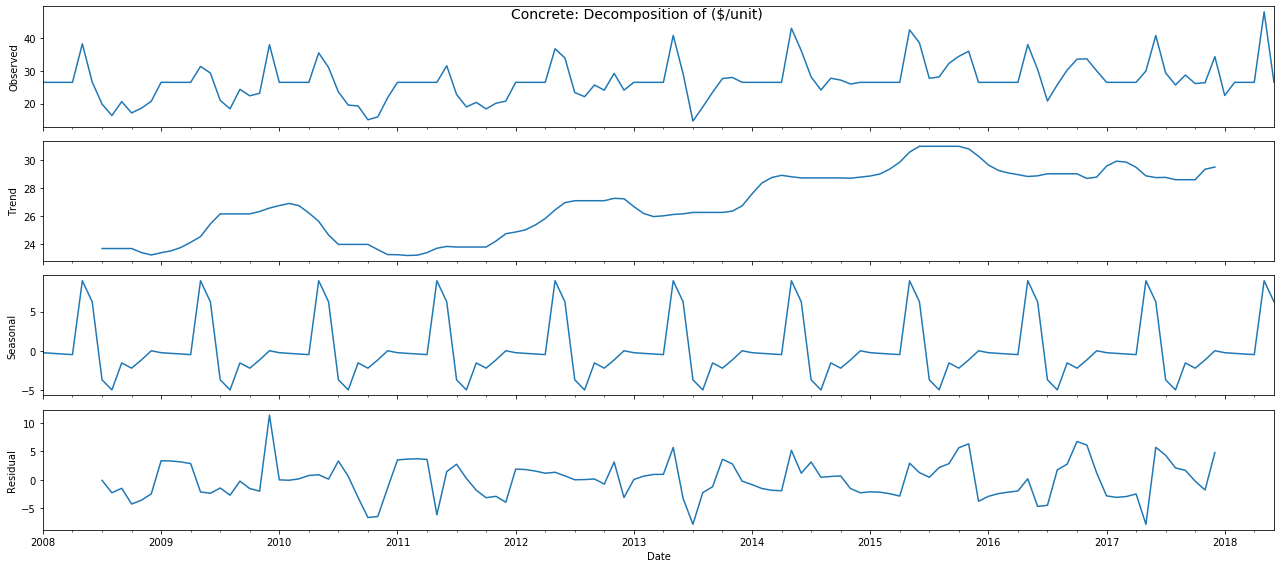

In [670]:
concrete = construction_materials['price_concrete'].resample('MS').median()
concrete = concrete['2008':]

# Missing 5 values, replace with median
#concrete = glass.rolling(4, min_periods=1,).median()
concrete = concrete.fillna(concrete.median())

decomp_plots(concrete, 'Concrete: Decomposition of ($/unit)') 

# Train/Test Split
concrete_train, concrete_test = train_test_split_ts(concrete)

In [640]:
#optmize_arima(concrete_train)
# ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:43.87061680425285

concrete_mod = sm.tsa.statespace.SARIMAX(concrete_train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

concrete_results = concrete_mod.fit()
print(concrete_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5413      0.090      6.012      0.000       0.365       0.718
ma.L1         -1.0000    138.985     -0.007      0.994    -273.405     271.405
ar.S.L12      -0.3819      0.060     -6.408      0.000      -0.499      -0.265
sigma2        11.3228   1573.945      0.007      0.994   -3073.552    3096.198


In [641]:
mean_predicted_values, confidence_interval_predicted_values = fit_predictions(concrete_mod.fit(), 
                                                                              len(concrete_test), 
                                                                              concrete_test)

Root mean squared error:  4.414664691814993
Mean absolute error:  3.5011260856358426


# 4e     SARIMA Plywood

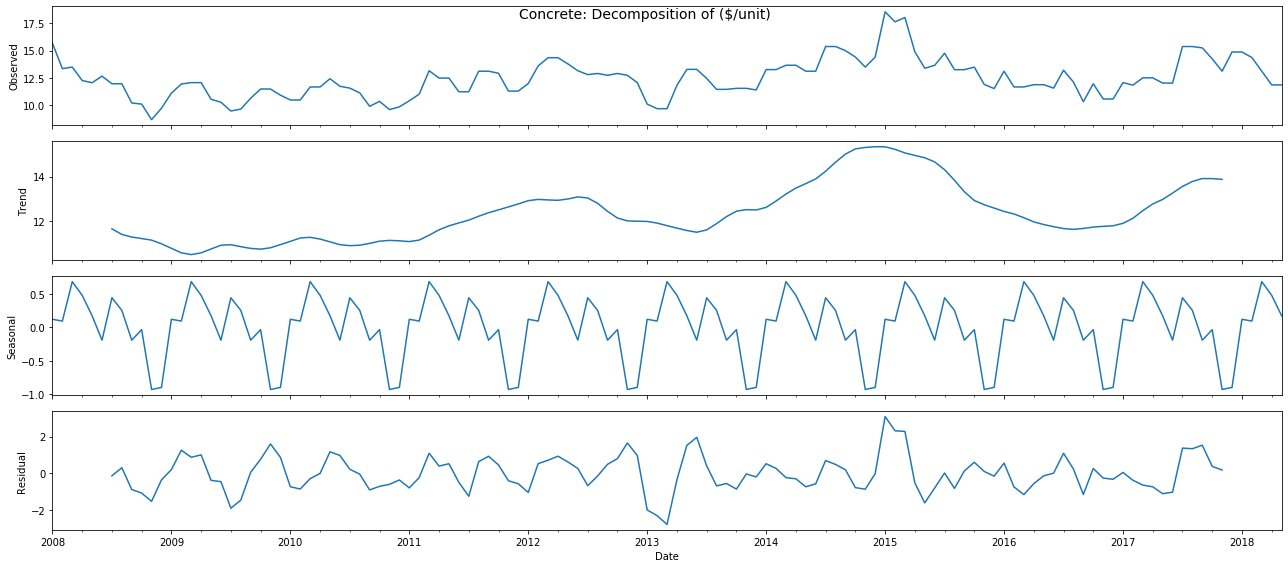

In [642]:
plywood = construction_materials['price_plywood'].resample('MS').median()
plywood = plywood['2008':]

# Missing 5 values, replace with median
plywood = plywood.rolling(4,min_periods=1,).median()

plywood = plywood.dropna()
decomp_plots(plywood, 'Concrete: Decomposition of ($/unit)') 

# Train/Test Split
plywood_train, plywood_test = train_test_split_ts(plywood)

In [643]:
#optmize_arima(plywood_train)
# ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:248.19314856945647

plywood_mod = sm.tsa.statespace.SARIMAX(plywood_train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

plywood_results = plywood_mod.fit()
print(plywood_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7483      0.079      9.440      0.000       0.593       0.904
ma.L1          0.3096      0.144      2.150      0.032       0.027       0.592
sigma2         1.4513      0.207      7.026      0.000       1.046       1.856


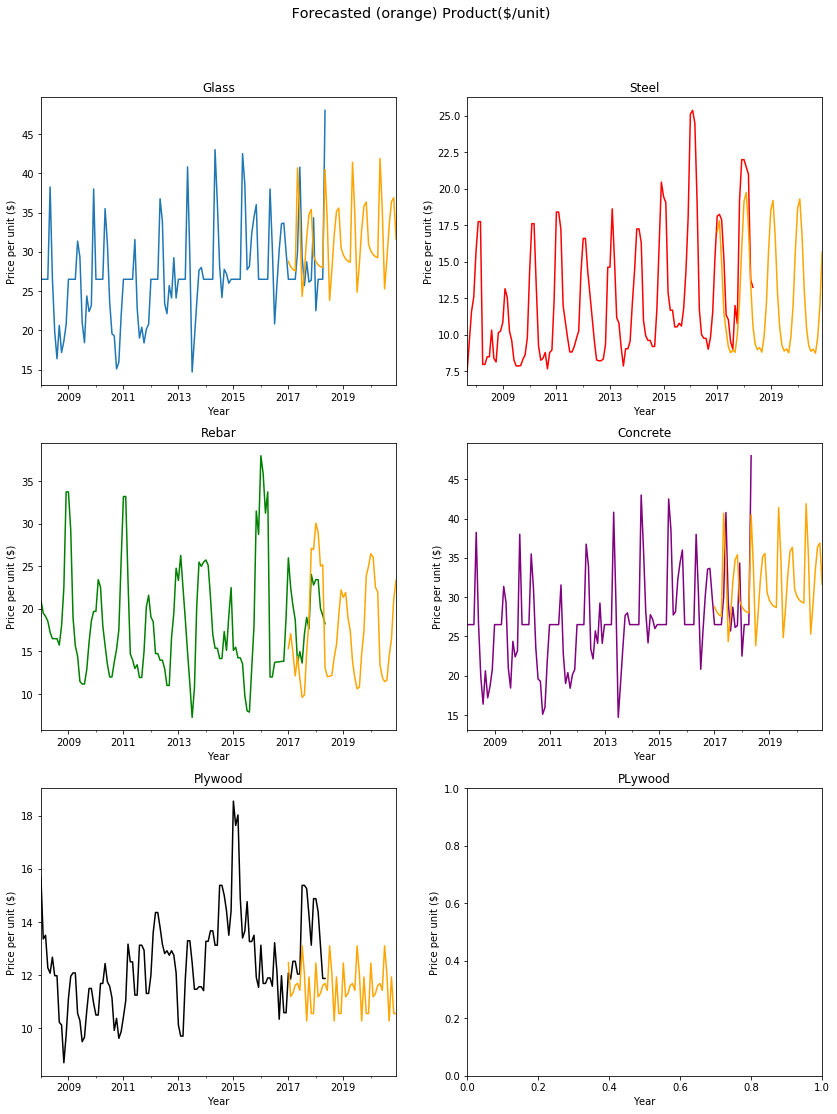

In [644]:
# Plotting a forecast
# Question: 3) What does the data look like?
# Plotting the Price per unit over time to visualize if their are any obvious trends

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,18))
st = fig.suptitle(" Forecasted (orange) Product($/unit)", fontsize="x-large")
# shift subplots down:
st.set_y(0.95)

ax11 = axes[0][0]
ax12 = axes[0][1]
ax21 = axes[1][0]
ax22 = axes[1][1]
ax13 = axes[2][0]

# gca stands for 'get current axis'
ax = plt.gca()


# Glass Plot
glass.plot(kind='line',x='Date',y='price_glass',
                            legend=False, ax=ax11)
# multi-step out-of-sample forecast
glass_forecast = glass_results.forecast(steps=48)
glass_forecast.plot(legend=False, ax=ax11, color='orange')

# Add title and axis names
plt.title('Glass')
plt.ylabel('Price per unit ($)')
plt.xlabel('Year')


# Steel Plot
steel.plot(kind='line',x='Date',y='price_steel',
                            legend=False, color='red', ax=ax12)
# multi-step out-of-sample forecast
steel_forecast = steel_results.forecast(steps=48)
steel_forecast.plot(legend=False, ax=ax12, color='orange')
# Add title and axis names
plt.title('Steel')
plt.ylabel('Price per unit ($)')
plt.xlabel('Year')


# Rebar Plot
rebar.plot(kind='line',x='Date',y='price_rebar',
                            legend=False, color='green', ax=ax21)
# multi-step out-of-sample forecast
rebar_forecast = rebar_results.forecast(steps=48)
rebar_forecast.plot(legend=False, ax=ax21, color='orange')
# Add title and axis names
plt.title('Rebar')
plt.ylabel('Price per unit ($)')
plt.xlabel('Year')


# Concrete Plot
concrete.plot(kind='line',x='Date',y='price_concrete',
                            legend=False, color='purple', ax=ax22)
# multi-step out-of-sample forecast
concrete_forecast = concrete_results.forecast(steps=48)
concrete_forecast.plot(legend=False, ax=ax22, color='orange')
# Add title and axis names
plt.title('Concrete')
plt.ylabel('Price per unit ($)')
plt.xlabel('Year')


# Plywood PLot
plywood.plot(kind='line',x='Date',y='price_plywood',
                            legend=False, color='black', ax=ax13)
# multi-step out-of-sample forecast
plywood_forecast = plywood_results.forecast(steps=48)
plywood_forecast.plot(legend=False, ax=ax13, color='orange')
# Add title and axis names
plt.title('PLywood')
plt.ylabel('Price per unit ($)')
plt.xlabel('Year')



# Set labels
ax11.set_title('Glass')
ax11.set_ylabel('Price per unit ($)')
ax11.set_xlabel('Year')

ax12.set_title('Steel')
ax12.set_ylabel('Price per unit ($)')
ax12.set_xlabel('Year')

ax21.set_title('Rebar')
ax21.set_ylabel('Price per unit ($)')
ax21.set_xlabel('Year')

ax22.set_title('Concrete')
ax22.set_ylabel('Price per unit ($)')
ax22.set_xlabel('Year')

ax13.set_title('Plywood')
ax13.set_ylabel('Price per unit ($)')
ax13.set_xlabel('Year')

plt.show()

In [645]:
# Forecasting the price of products out until 2025
concrete_forecast = concrete_results.forecast(steps= 97)
steel_forecast = steel_results.forecast(steps= 97)
rebar_forecast = rebar_results.forecast(steps= 97)
plywood_forecast = plywood_results.forecast(steps= 97)
glass_forecast = glass_results.forecast(steps= 97)

In [646]:
# Function for manager to determine the best time to purchase a product

def product_forecast(forecast_input, product):
    '''
    This is a function that allows the manager to input both the day he is interesting
    in purchasing a product and the name of that particular product.
    This function will return the best time to purchase in the following six months
    and the amount he would save by purchasing when the projected cost is a minimum. 
    '''
    if product == 'concrete':
        future = concrete_forecast[forecast_input:]
    elif product == 'steel':
        future = steel_forecast[forecast_input:]
    elif product == 'rebar':
        future = rebar_forecast[forecast_input:]    
    elif product == 'plywood':
        future = plywood_forecast[forecast_input:]
    elif product == 'glass':
        future = glass_forecast[forecast_input:]
    else:
        print('Could not find this product')
        return
    
    if len(future) > 6:
        future = future[0:6]

    if future[0] == future.min:
        print('This is the best time to purchase!')
    else:
        money_saved = (abs(future.min() - future[0])/((future.min() + future[0])/2)) * 100
        money_saved =  int(money_saved)
        time_min_cost = future.index.min()
        #time_min_cost_m = time_min_cost.month()
        print('You would save', money_saved, '% on $/unit if you purchased', product, 
              'this upcoming', time_min_cost.month_name(),'.')

In [650]:
product_forecast('2022-10-12', 'plywood')

You would save 0 % on $/unit if you purchased plywood this upcoming November .


# 5    Concluding Remarks:

Most of the 5 products of interest have a seasonal/cyclical nature to the pricing.
As a result, including both trend and seasonal information allowed us to predict future
costs with fairly decent accuracy. Despite these findings, future work should consider
a more sophisticated method, such as Facebook prophet since this algorithm can inherently handle missing data. I had to heavily rely on averaging and filling in data in order to predict future costs, which may not be fully representative of real-life data. 


Future Work:

1) Try using a new and morre sophisticed model, such as prochet in order to see if accuracy can be imporved for the model

2) Split the training/tesing data into folds that look at different time frames


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


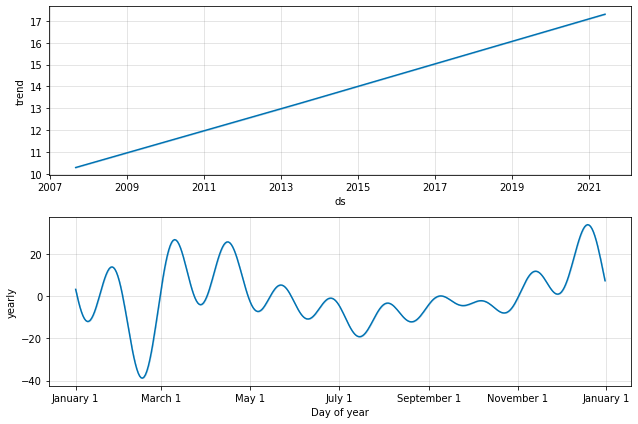

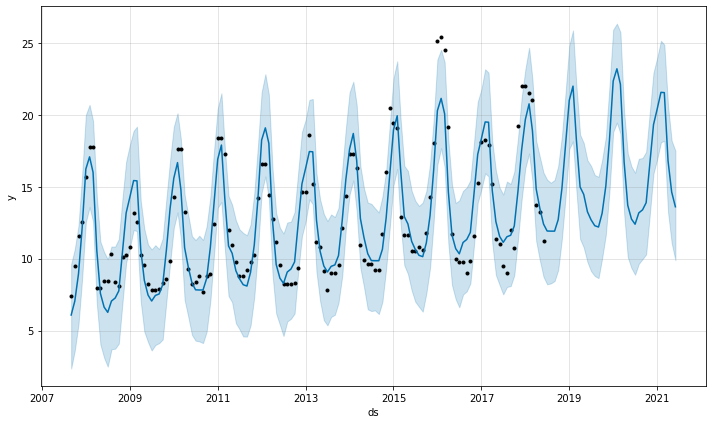

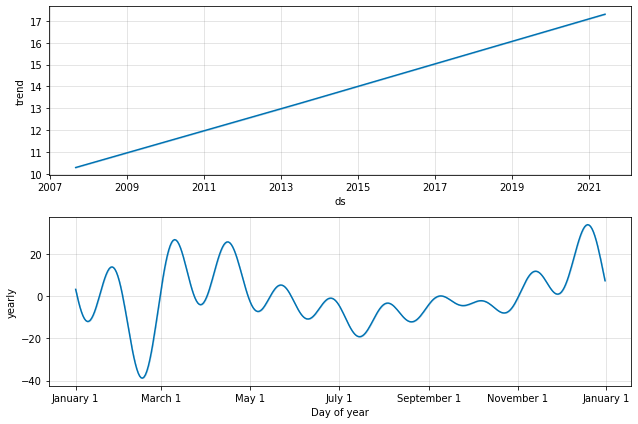

In [671]:
# Example of using Prophet:
# set the uncertainty interval to 95% (the Prophet default is 80%)
steel_df = steel.to_frame()
steel_df.columns
steel_df = steel_df.rename(columns={'price_steel': 'y'})
steel_df['ds'] = steel_df.index
steel_df.head()
my_model = Prophet(interval_width=0.95)
my_model.fit(steel_df)
future_dates = my_model.make_future_dataframe(periods=36, freq='MS')
future_dates.tail()
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
my_model.plot(forecast,
              uncertainty=True)

my_model.plot_components(forecast)